In [1]:
import sys
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer

import torch
from torch import optim
from torch.autograd import Variable,gradcheck
from torch.utils.data import DataLoader

import seaborn as sns

sys.path.append('../scripts')

In [2]:
class DatasetLoader:
    def __init__(self, path):
        with open(path, 'r') as f:
            self.data = f.read().splitlines()
        split_tab = lambda x: [item.split('\t') for item in x]
        self.data = split_tab(self.data)
        self.num_data = len(self.data)
        self.arr = np.array(self.data)
        self.df = pd.DataFrame({
            'start': self.arr[:, 0],
            'relation': self.arr[:, 1],
            'dest': self.arr[:, 2]
        })
        
        # get one_hot relation
        one_hot_relation = [[item[1],] for item in self.data]
        self.enc = OneHotEncoder().fit(one_hot_relation)
        self.one_hot_relation = self.enc.transform(one_hot_relation).toarray()
        self.y_index = np.argmax(self.one_hot_relation, axis=1)
        
        # get unique edges and nodes
        self.unique_relations = np.unique(self.arr[:, 1])
        self.num_relations = len(self.unique_relations)
        self.unique_nodes = np.unique(self.arr[:, (0, 2)])
        self.num_nodes = len(self.unique_nodes)
        self.node_dict = self.get_node_dict()
    
    def encode_index(self, ext_dict=None):
        if ext_dict is None:
            enc_dict = self.node_dict
        else:
            enc_dict = ext_dict
        start = self.arr[:, 0]
        end = self.arr[:, 2]
        start = np.stack([enc_dict[item] for item in start])
        end = np.stack([enc_dict[item] for item in end])
        return np.concatenate((start, end), axis=1)
    
    def get_node_dict(self):
        unpack_bits = lambda num, m: np.array(list(np.binary_repr(num).zfill(m))).astype(np.uint8)
        m = np.log2(self.num_nodes).astype(np.uint8) + 1
        return {self.unique_nodes[i]: unpack_bits(i, m) for i in range(self.num_nodes)}

In [3]:
verbose = False
data_path = '../datasets/WN18RR/'    

# datasets
train = DatasetLoader(data_path + 'train.txt')
test = DatasetLoader(data_path + 'test.txt')
val = DatasetLoader(data_path + 'valid.txt')

# get uniques
relations_all = np.concatenate((train.arr[:, 1], val.arr[:, 1], test.arr[:, 1]))
relations = np.unique(relations_all)
nodes_all = np.concatenate((train.arr[:, (0, 2)], val.arr[:, (0, 2)], test.arr[:, (0, 2)]))
nodes = np.unique(nodes_all)
np.random.shuffle(nodes)

print('Number of Training:', len(train.arr))
print('Number of Test:', len(test.arr))
print('Number of Validation:', len(val.arr))
print()
print('Number of Total Relations:', len(relations))
print('Training Relations:', len(np.unique(train.arr[:, 1])))
print('Valiation Relations:', len(np.unique(val.arr[:, 1])))
print('Test Relations:', len(np.unique(test.arr[:, 1])))
print()
print('Number of Total Nodes:', len(nodes))
print('Training Nodes:', len(np.unique(train.arr[:, (0, 2)])))
print('Valiation Nodes:', len(np.unique(val.arr[:, (0, 2)])))
print('Test Nodes:', len(np.unique(test.arr[:, (0, 2)])))

if verbose:
    print('Unique Relations:', relations)

Number of Training: 86835
Number of Test: 3134
Number of Validation: 3034

Number of Total Relations: 11
Training Relations: 11
Valiation Relations: 11
Test Relations: 11

Number of Total Nodes: 40943
Training Nodes: 40559
Valiation Nodes: 5173
Test Nodes: 5323


In [4]:
# create encoded nodes dict
unpack_bits = lambda num, m: np.array(list(np.binary_repr(num).zfill(m))).astype(np.uint8)
m = np.log2(len(nodes)).astype(np.uint8) + 1
node_dict = {nodes[i]: unpack_bits(i, m) for i in range(len(nodes))}

X_train = train.encode_index(ext_dict=node_dict)
X_val = val.encode_index(ext_dict=node_dict)
X_test = test.encode_index(ext_dict=node_dict)

y_train = train.y_index
y_val = val.y_index
y_test = test.y_index

In [5]:
%%time

from DNN import DNN

# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

# model settings
D_in  = X_train.shape[1]
D_out = len(relations)
H = 100
Depth = 3
NUMEPOCHS = 500
Batch_size = 2000

model = DNN(
    input_size=D_in,
    output_size=D_out,
    hidden_size=H,
    depth=Depth
).to(device)

# Loss Function
criterion = torch.nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adamax(model.parameters())

CPU times: user 1.93 s, sys: 766 ms, total: 2.69 s
Wall time: 2.72 s


In [6]:
# Input Data
trainX = Variable(torch.from_numpy(X_train).float())
trainY = Variable(torch.from_numpy(y_train).long())
valX = Variable(torch.from_numpy(X_val).float())
valY = Variable(torch.from_numpy(y_val).long())
testX = Variable(torch.from_numpy(X_test).float())
testY = Variable(torch.from_numpy(y_test).long())

print(trainX.shape)
print(trainY.shape)
print(valX.shape)
print(valY.shape)
print(testX.shape)
print(testY.shape)

if torch.cuda.is_available():
    trainX = trainX.to(device)
    trainY = trainY.to(device)
    testX = testX.to(device)
    testY = testY.to(device)
    valX = valX.to(device)
    valY = valY.to(device)
    
data_train_loader = DataLoader(
    list(zip(trainX,trainY)), 
    batch_size=Batch_size, 
    shuffle=True
)

torch.Size([86835, 32])
torch.Size([86835])
torch.Size([3034, 32])
torch.Size([3034])
torch.Size([3134, 32])
torch.Size([3134])


In [7]:
%%time
# Train the model
print("Epochs")
loss_list = np.zeros(NUMEPOCHS)
val_list = np.zeros(NUMEPOCHS)

early_stop_win_size = 20

for epoch in range(NUMEPOCHS):
    losses = 0
    for batchX, batchY in data_train_loader: 
        # Forward pass
        outputs = model(batchX)
        loss = criterion(outputs, batchY)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()     
        optimizer.step()
        losses += loss.item()
    losses /= len(data_train_loader)
    loss_list[epoch] = losses
    val_list[epoch] = criterion(model(valX), valY).item()
    
    # early stop to prevent overfitting  
    if epoch > early_stop_win_size:
        mean_val_loss = np.mean(val_list[epoch-early_stop_win_size:epoch+1])
        if val_list[epoch] > mean_val_loss:
            print('Early stop at epoch', epoch)
            val_list = val_list[:epoch + 1]
            loss_list = loss_list[:epoch + 1]
            break
    
    # Print Epochs and Losses to Monitor Convergence
    if epoch % 50 == 0:
        print("{}".format(epoch),end = ", ")
        print(losses, val_list[epoch])
        
print('\nTraining Complete')

Epochs
0, 1.6517834717577153 1.553648829460144
50, 1.3785558695142919 1.4101084470748901
100, 1.2712329897013577 1.3275004625320435
Early stop at epoch 126

Training Complete
CPU times: user 45.6 s, sys: 606 ms, total: 46.2 s
Wall time: 46.2 s


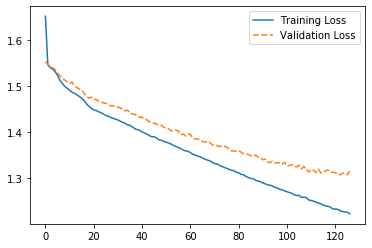

In [8]:
loss_df = pd.DataFrame({
    'Training Loss': loss_list,
    'Validation Loss': val_list
})
sns.lineplot(data=loss_df)

In [9]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.metrics import label_ranking_loss, label_ranking_average_precision_score, coverage_error
def evaluate(X, Y, name):
    score = model(X).detach().cpu().numpy()
    pred = np.argmax(score, axis=1)
    score = (
        score - np.min(score, axis=1)[:, np.newaxis]
    ) / (
        np.max(score, axis=1) - np.min(score, axis=1)
    )[:, np.newaxis]
    
    true = Y.cpu().numpy()
    true_score = np.zeros_like(score)
    true_score[np.arange(len(true_score)), true] += 1
    
    hit_3 = score.argsort(axis=1)[np.arange(len(score)), -3:]
    hit_10 = score.argsort(axis=1)[np.arange(len(score)), -10:]
    hit_3 = np.sum(np.max(true[:, np.newaxis] == hit_3, axis=1)) / len(score)
    hit_10 = np.sum(np.max(true[:, np.newaxis] == hit_10, axis=1)) / len(score)
    
    print(name + ' Accuracy:\t', accuracy_score(true, pred))
    print(name + ' F1-micro:\t', f1_score(true, pred, average='micro'))
    print(name + ' F1-macro:\t', f1_score(true, pred, average='macro'))
    print(name + ' MRR:\t', label_ranking_average_precision_score(true_score, score))
    print(name + ' Ranking Loss:\t', label_ranking_loss(true_score, score))
    print(name + ' Coverage Error:\t', coverage_error(true_score, score))
    print(name + ' Hit@1:\t', accuracy_score(true, pred))
    print(name + ' Hit@3:\t', hit_3)
    print(name + ' Hit@10:\t', hit_10)
    print()

In [10]:
print('Test Labels :\n', testY.cpu().numpy())
print('Test Predictions :\n', np.argmax(model(testX).detach().cpu().numpy(), axis=1))
print()

evaluate(trainX, trainY, 'Training')
evaluate(valX, valY, 'Validation')
evaluate(testX, testY, 'Test')

Test Labels :
 [ 7 10  6 ...  1  2  3]
Test Predictions :
 [7 1 6 ... 3 3 3]

Training Accuracy:	 0.5149075833477285
Training F1-micro:	 0.5149075833477285
Training F1-macro:	 0.3789540573407701


/home/jayroxis/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Training MRR:	 0.7114762398309181
Training Ranking Loss:	 0.0901284044452122
Training Coverage Error:	 1.9012840444521217
Training Hit@1:	 0.5149075833477285
Training Hit@3:	 0.8965969942995335
Training Hit@10:	 0.9997466459376979

Validation Accuracy:	 0.48055372445616346
Validation F1-micro:	 0.48055372445616346
Validation F1-macro:	 0.3386825129137016
Validation MRR:	 0.69046586973416


/home/jayroxis/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Validation Ranking Loss:	 0.09924192485168096
Validation Coverage Error:	 1.9924192485168095
Validation Hit@1:	 0.48055372445616346
Validation Hit@3:	 0.8839815425181279
Validation Hit@10:	 0.9996704021094265

Test Accuracy:	 0.4856413529036375
Test F1-micro:	 0.4856413529036375
Test F1-macro:	 0.3624229512762107
Test MRR:	 0.6936066610125309


/home/jayroxis/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Test Ranking Loss:	 0.09818123803446077
Test Coverage Error:	 1.9818123803446075
Test Hit@1:	 0.4856413529036375
Test Hit@3:	 0.8864071474154436
Test Hit@10:	 0.9984045947670709

